In [1]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")

sys.path.append('/home/ubuntu2/store_sales_time_series_forecasting_kaggle/src')

import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from sklearn.ensemble import IsolationForest

from sales_project.utils import iqr_filter, reduce_size
from sales_project.plotters import linear_plot, hist_box_plot, train_submission_countplot

pd.set_option('display.max_rows', 100)

sns.set_theme(context='talk', style="darkgrid", palette='dark', font='sans-serif')
tqdm.pandas()

In [ ]:
message = lambda df, df2: print(f"Removed {len(df) - len(df2)} outliers, ratio - {round(100 * (len(df) - len(df2)) / len(df), 2)}%")

# I. Reading data

In [3]:
data = {}
for file in os.listdir('../data/raw'):
    if file.endswith('.csv'):
        data[file.replace('.csv', '')] = pd.read_csv(f'../data/raw/{file}')

In [4]:
df = pd.concat([data['train'], data['test']], ignore_index=True)
df = df.merge(data['transactions'], on=['date', 'store_nbr'], how='left')
df = df.merge(data['stores'], on=['store_nbr'], how='left')
df = df.merge(data['oil'], on=['date'], how='left')

df['is_submission'] = df['sales'].isnull()

In [5]:
df['date'] = pd.to_datetime(df['date'])

Reducing the memory consumption by data types

In [6]:
reduce_size(df)

  0%|          | 0/13 [00:00<?, ?it/s]

# II. Duplicates

First off, check duplicated along id column

In [7]:
print('Number of duplicates along id: ', df.duplicated(subset='id', keep=False).sum()) 

Number of duplicates along id:  0


There are no duplicates.  
Let's check other columns

In [8]:
cols = list(df.columns)
cols.remove('id')
print('Number of duplicates along other columns: ', df.duplicated(subset=cols, keep=False).sum()) 

Number of duplicates along other columns:  0


In [9]:
cols = ['date', 'store_nbr', 'family']
print('Number of duplicates along other columns: ', df.duplicated(subset=cols, keep=False).sum()) 

Number of duplicates along other columns:  0


Still no duplicates

# III. Missing data

In [10]:
for col in df.columns:
    n_null = df[col].isnull().sum()
    if n_null > 0:
        print(f"{col}:")
        print(f"{n_null} NaNs, ratio - {round(n_null/len(df)*100, 2)}%")

sales:
28512 NaNs, ratio - 0.94%
transactions:
274296 NaNs, ratio - 9.05%
dcoilwtico:
935550 NaNs, ratio - 30.88%


In [11]:
data['test'].shape

(28512, 5)

There are missing data in `sales` column, but this is a submission part of the dataset, so it is ok  
However, there are quite a lof of NaNs in `transactions` and `dcoilwtico` columns

### dcoilwtico

Let's start with `dcoilwtico`.  
Originally, this column was a part of a dataframe, where for each date a corresponding `dcoilwtico` value  
was stated. It seems, that there are dates with no data for `dcoilwtico`

Let's consider only unique pairs [`date`, `dcoilwtico`]

In [12]:
df2 = df[['date', 'dcoilwtico']].drop_duplicates().sort_values(by='date')
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1700 entries, 0 to 3027618
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1700 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float32       
dtypes: datetime64[ns](1), float32(1)
memory usage: 33.2 KB


In [13]:
df2

,date,dcoilwtico
0,2013-01-01,NaN
1782,2013-01-02,93.139999
3564,2013-01-03,92.970001
5346,2013-01-04,93.120003
7128,2013-01-05,NaN
...,...,...
3020490,2017-08-27,NaN
3022272,2017-08-28,46.400002
3024054,2017-08-29,46.459999
3025836,2017-08-30,45.959999


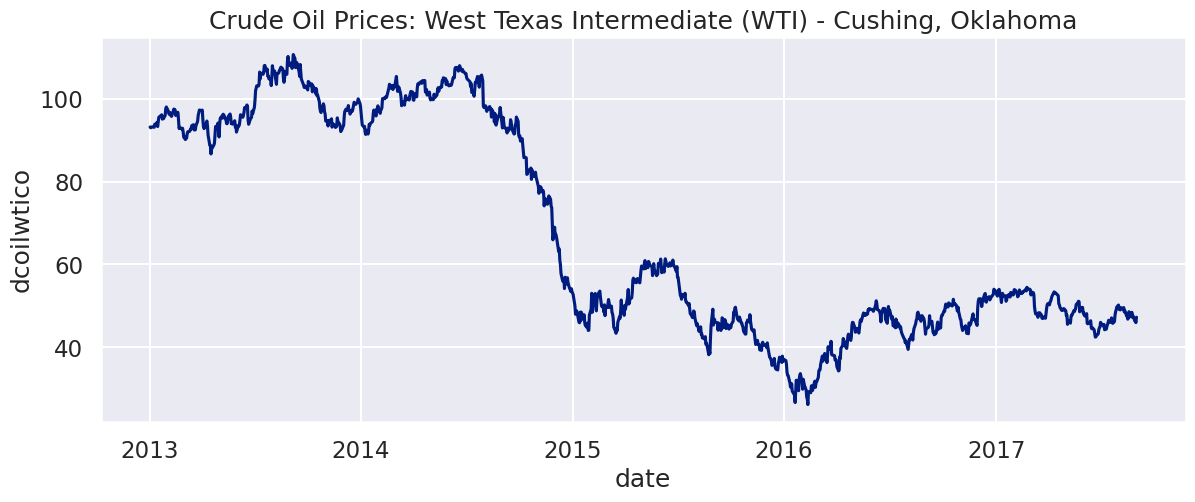

In [14]:
linear_plot(
    data=df2,
    x='date',
    y='dcoilwtico',
    title='Crude Oil Prices: West Texas Intermediate (WTI) - Cushing, Oklahoma',
)

It can be seen from the time series above, that there are no major spikes. Therefore, it is possible to apply   
an interpolation method to deal with missing data. Let's consider an interpolation via a CubicSpline

In [15]:
cs = CubicSpline(
    df2.dropna()["date"],
    df2.dropna()["dcoilwtico"],
)
df2.loc[df2["dcoilwtico"].isnull(), "dcoilwtico"] = cs(
    df2[df2["dcoilwtico"].isnull()]["date"]
)


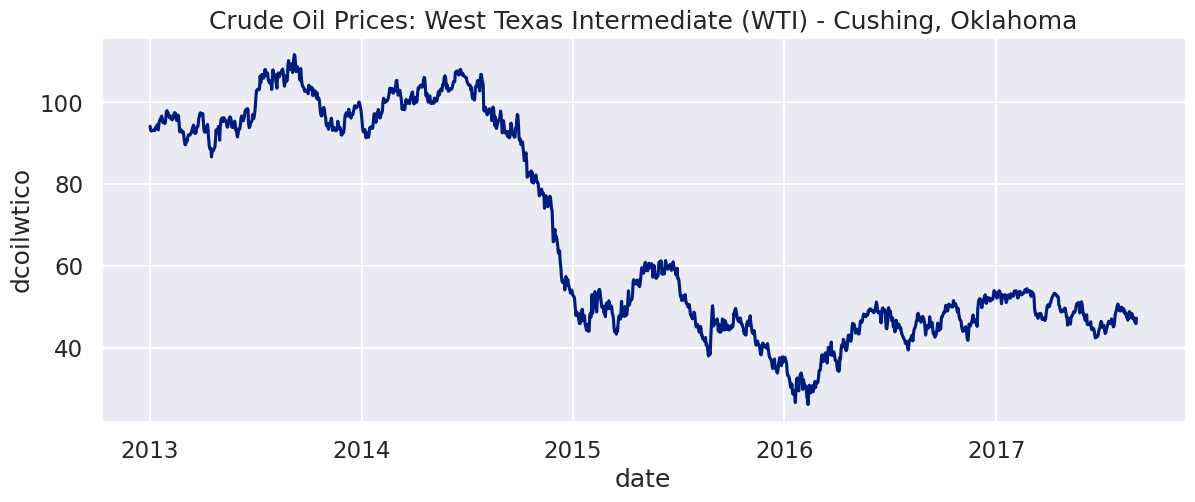

In [16]:
linear_plot(
    data=df2,
    x='date',
    y='dcoilwtico',
    title='Crude Oil Prices: West Texas Intermediate (WTI) - Cushing, Oklahoma',
)

Let's apply changes to the main dataframe

In [17]:
df = (
    df
    .drop(columns=['dcoilwtico'])
    .merge(df2, on='date', how='left')
)
df['dcoilwtico'].isnull().sum()

0

### transactions

Originally, this column was a part of a dataframe, where for each `date` and `store_nbr` a corresponding `transactions` value  
was stated.

Let's consider only unique pairs [`date`, `store_nbr`, `transactions`]

In [18]:
df2 = df[['date', 'store_nbr', 'transactions']].drop_duplicates().sort_values(by=['date', 'store_nbr'])
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91800 entries, 0 to 3029235
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          91800 non-null  datetime64[ns]
 1   store_nbr     91800 non-null  uint8         
 2   transactions  83488 non-null  float32       
dtypes: datetime64[ns](1), float32(1), uint8(1)
memory usage: 1.8 MB


In [19]:
df2['transactions'].isnull().sum()

8312

In [ ]:
# for store_nbr in df2['store_nbr'].unique():
#     linear_plot(
#         data=df2.query(f'store_nbr == {store_nbr}'),
#         x='date',
#         y='transactions',
#         title=f'Transactions in store {store_nbr}',
#         figsize=(15, 2)
#     )

From the time series above it is clear, that for there are major spikes in the distribution for each store.  
Typically, they are located during the New Year holidays.  
On the other hand, it is possible to distinguish a clear trend and seasonality patterns in most cases.  
Therefore let's apply a time-based imputation by calculating a mean value over `store_nbr`, `month`, `week`

In [20]:
df2['year'] = df2.date.dt.year
df2['month'] = df2.date.dt.month
df2['week'] = df2.date.dt.isocalendar().week

df2['transactions'] = df2.groupby(['store_nbr', 'month', 'week'])['transactions'].transform(lambda x: x.fillna(x.mean()))

In [21]:
df2['transactions'].isnull().sum()

1267

There are still some missing data left. Let's use a `month`, `weekday` aggregation

In [22]:
df2['transactions'] = df2.groupby(['month', 'week'])['transactions'].transform(lambda x: x.fillna(x.mean()))
df2['transactions'].isnull().sum()

0

Let's apply changes to the main dataframe

In [23]:
df = (
    df
    .drop(columns=['transactions'])
    .merge(df2[['date', 'store_nbr', 'transactions']], on=['date', 'store_nbr'], how='left')
)
df['transactions'].isnull().sum()

0

# IV. Outliers



Let's separate features into the following groups:

    numerical features
    binary categorical features
    non-binary categorical features
    datetime features

In [25]:
df.dtypes

id                       uint32
date             datetime64[ns]
store_nbr                 uint8
family                   object
sales                   float32
onpromotion              uint16
city                     object
state                    object
type                     object
cluster                   uint8
is_submission              bool
dcoilwtico              float64
transactions            float32
dtype: object

In [26]:
df.nunique()

id               3029400
date                1700
store_nbr             54
family                33
sales             379610
onpromotion          367
city                  22
state                 16
type                   5
cluster               17
is_submission          2
dcoilwtico          1523
transactions        5652
dtype: int64

There are no binary features

In [38]:
date_col = 'date'
num_cols = ['sales', 'onpromotion', 'dcoilwtico', 'transactions']
cat_cols = ['family', 'city', 'state', 'type', 'cluster']

## A. Numerical columns

In [28]:
iqr_feats = {}
queries = []

### 1. sales

In [29]:
df['sales'].describe()

count    3.000888e+06
mean     3.577758e+02
std      1.092778e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.100000e+01
75%      1.958473e+02
max      1.247170e+05
Name: sales, dtype: float64

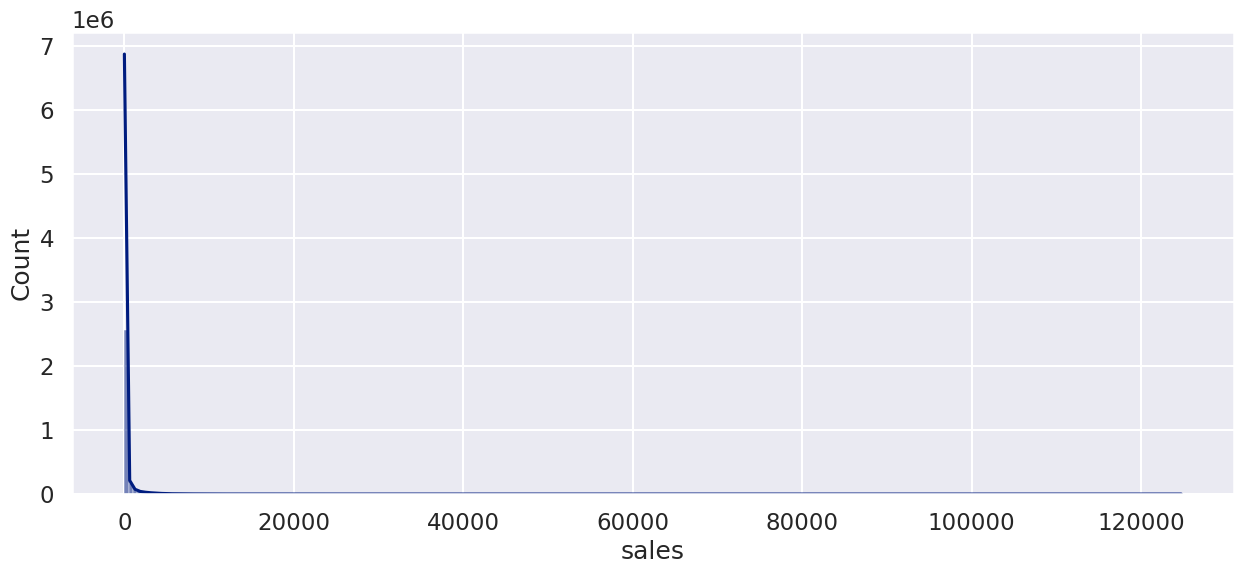

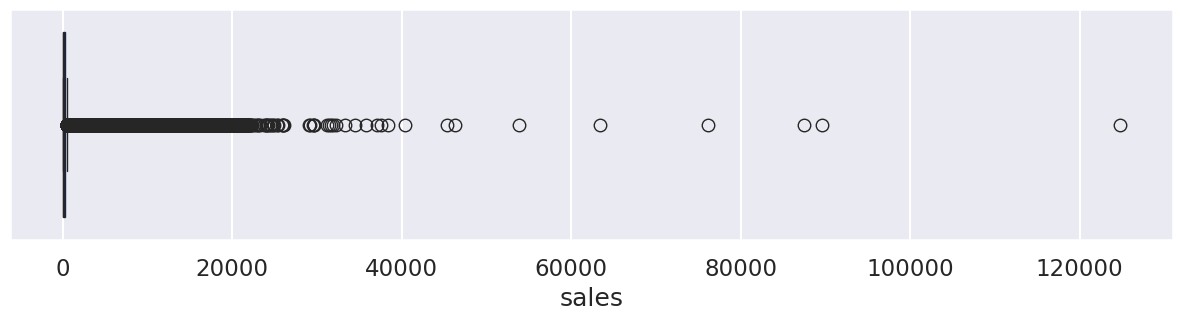

In [30]:
hist_box_plot(df[['sales']], 'sales', kde=True)

Let's apply IQR filter in order to remove too extreme sales values.  
Let `threshold` be equal to 15 instead of 1.5 so that not so many data is dropped

Removed 84221 outliers, ratio - 2.78%


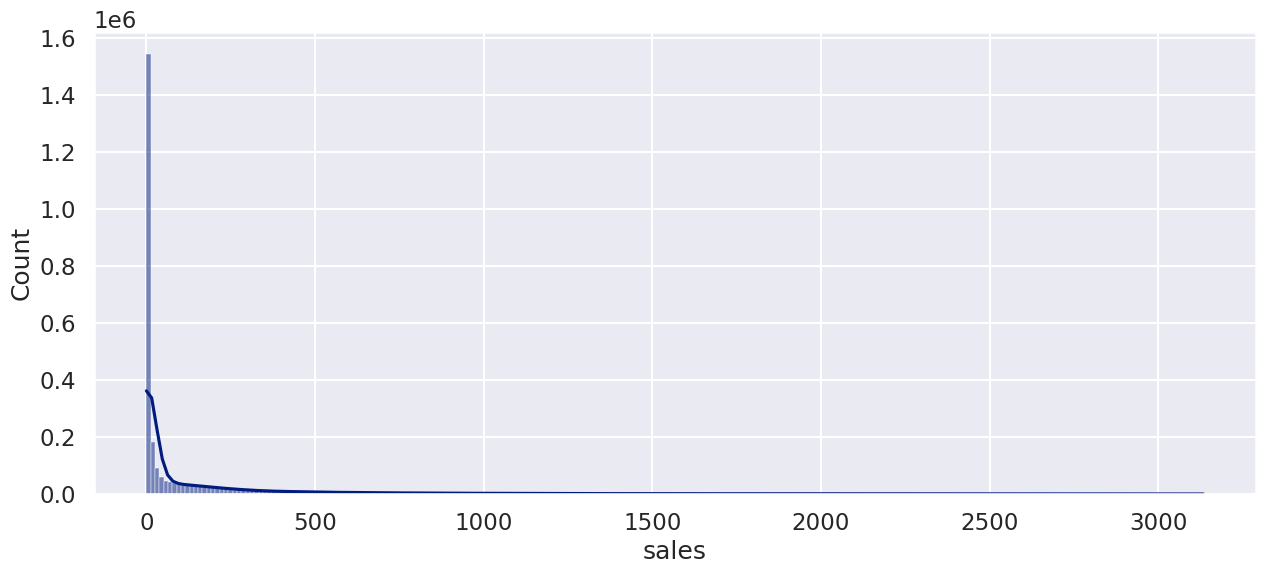

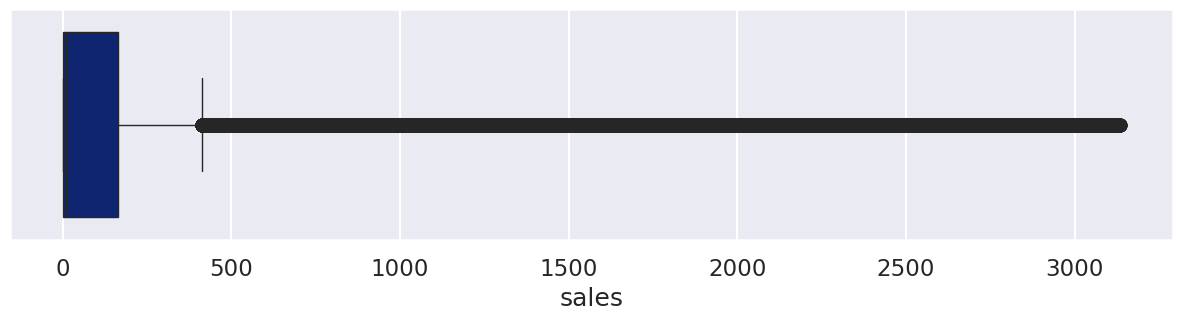

In [31]:
col = 'sales'
iqr_feats[col] = 15
df2 = iqr_filter(df.copy(), features={col: iqr_feats[col]}, is_submission_col='is_submission')
hist_box_plot(df2, col, kde=True)

It can be seen that there are a lot of zero values - days at which stores failed to sale any goods

### 2. dcoilwtico

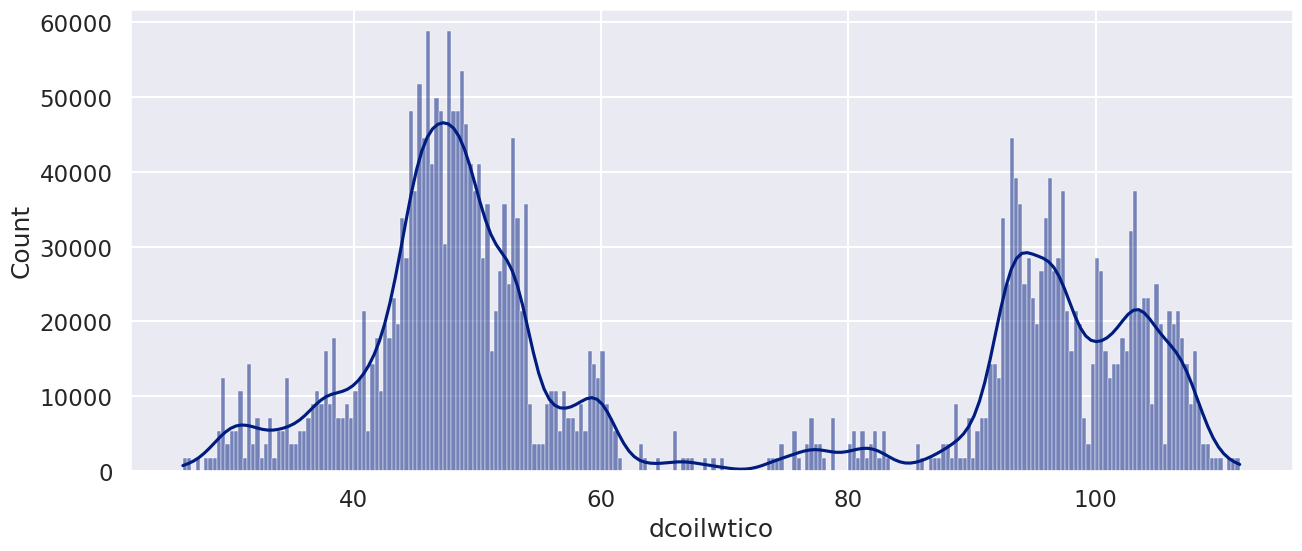

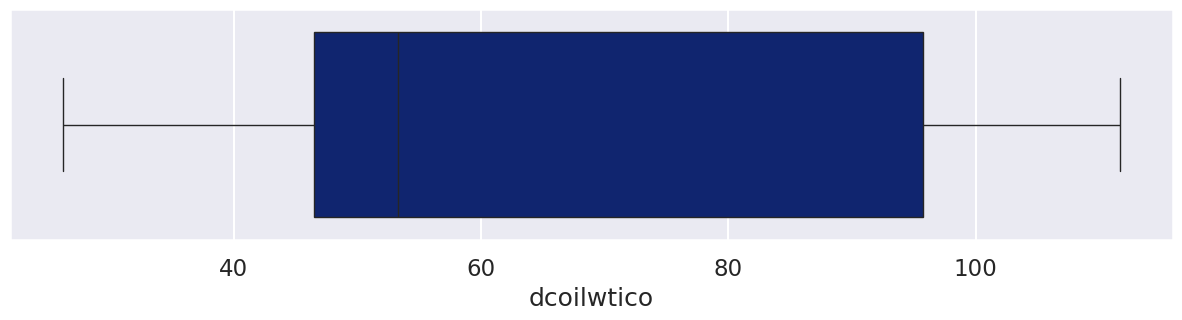

In [32]:
hist_box_plot(df[['dcoilwtico']], 'dcoilwtico', kde=True)

Although there are no outliers,  
it seems that this feature is sampled from two distributions with at least a different median value.  
If to analyse the time series plot earlier, it is clear that it is so due to a major decline in the  
price after 2015

### 3. transactions

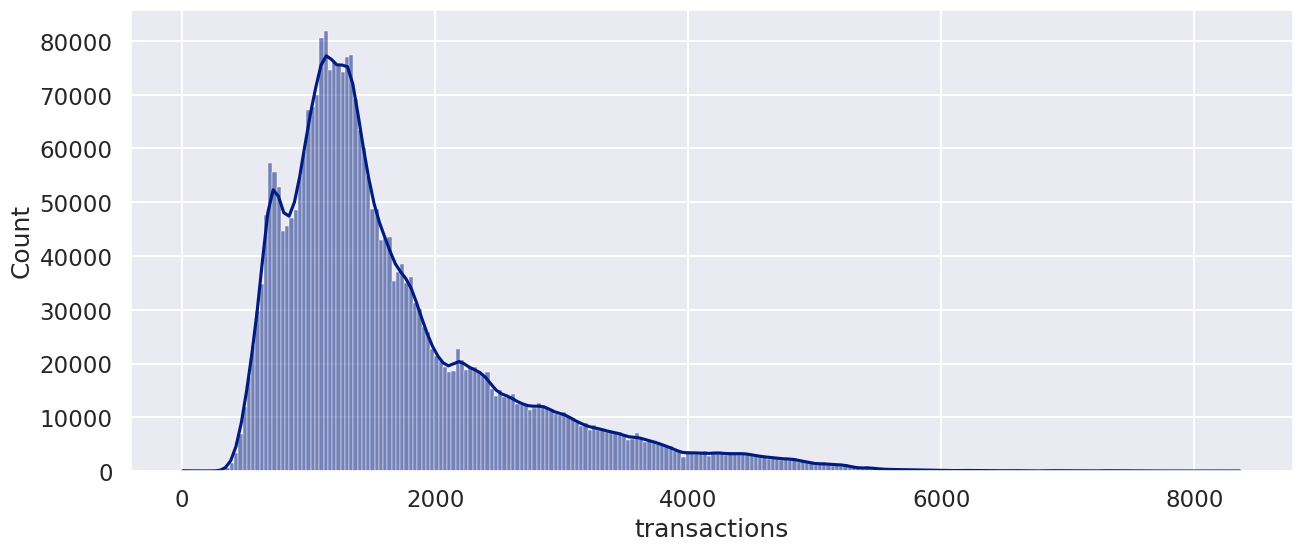

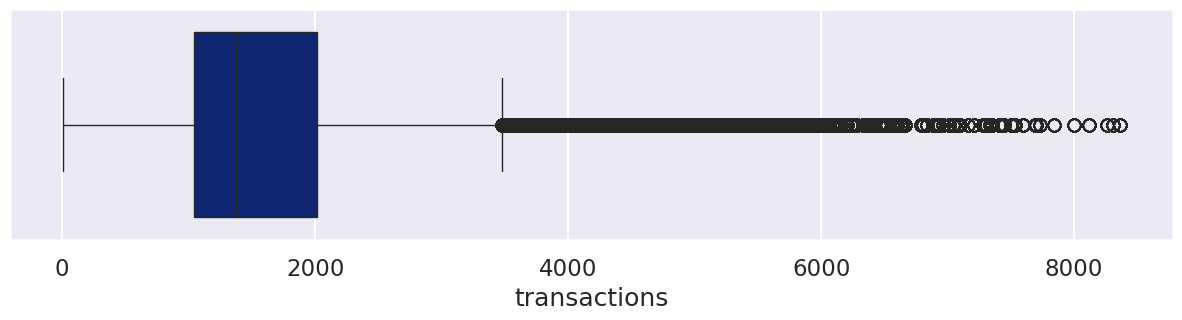

In [33]:
hist_box_plot(df[['transactions']], 'transactions', kde=True)

It seems like if to apply log1p transformtation, the distribution will lool like more normal.  
But let's leave it to the feature engineering part

Let's apply an IQR filter

Removed 23265 outliers, ratio - 0.77%


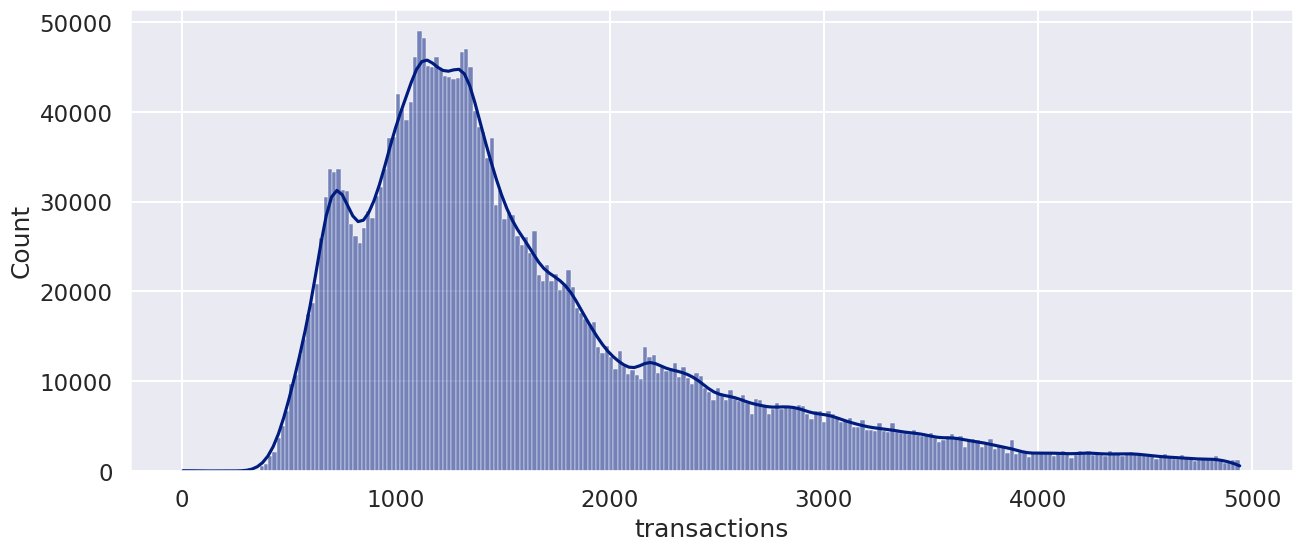

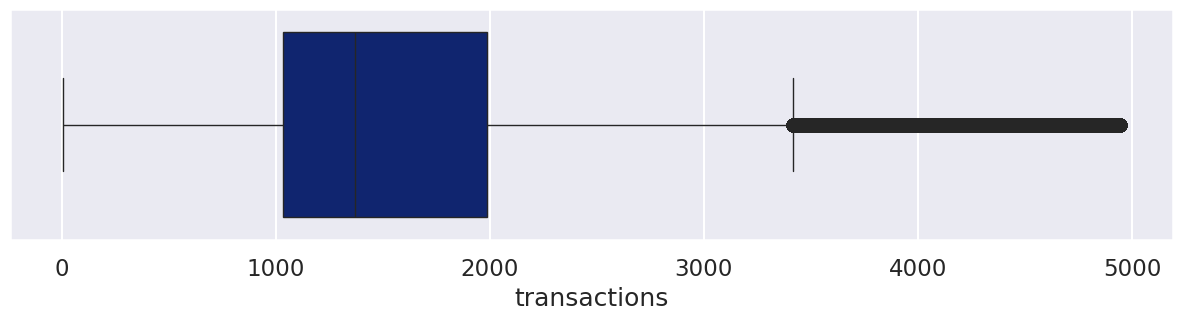

In [34]:
col = 'transactions'
iqr_feats[col] = 3
df2 = iqr_filter(df.copy(), features={col: iqr_feats[col]}, is_submission_col='is_submission')
hist_box_plot(df2, col, kde=True)

### 4. onpromotion

In [35]:
df['onpromotion'].describe()

count    3.029400e+06
mean     2.643830e+00
std      1.233287e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      7.410000e+02
Name: onpromotion, dtype: float64

In [36]:
df['onpromotion'].value_counts().head(20)

onpromotion
0     2405502
1      177093
2       80488
3       46510
4       32051
5       24999
6       22570
7       19351
8       16055
9       14363
10      13097
11      11435
12      10105
13       8767
14       7490
15       6592
16       6090
17       5400
18       5047
19       4647
Name: count, dtype: int64

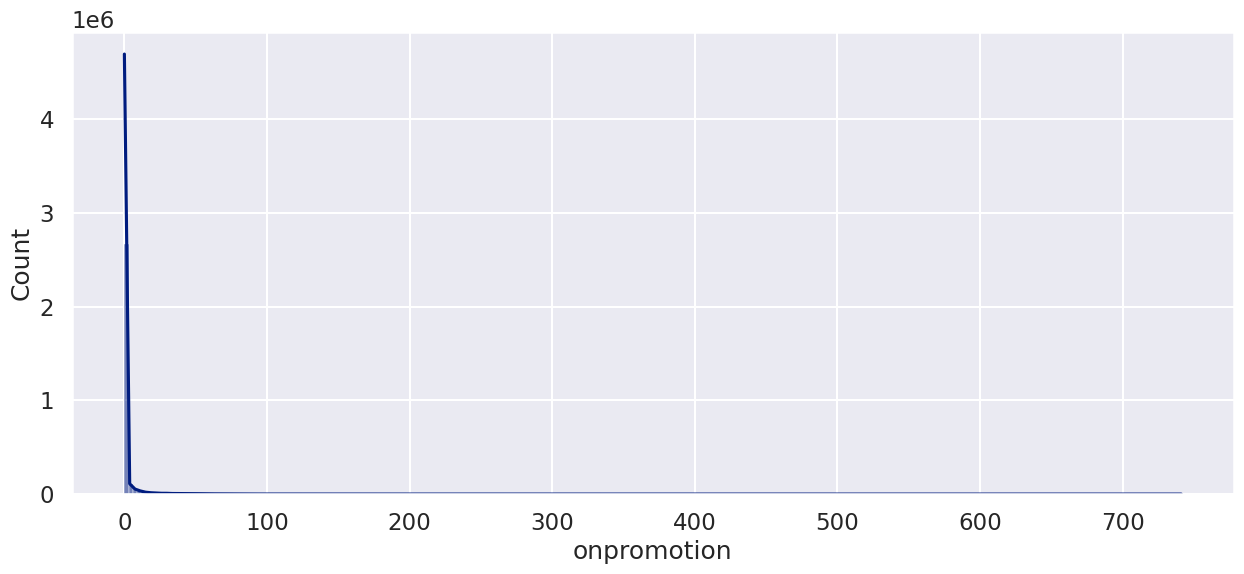

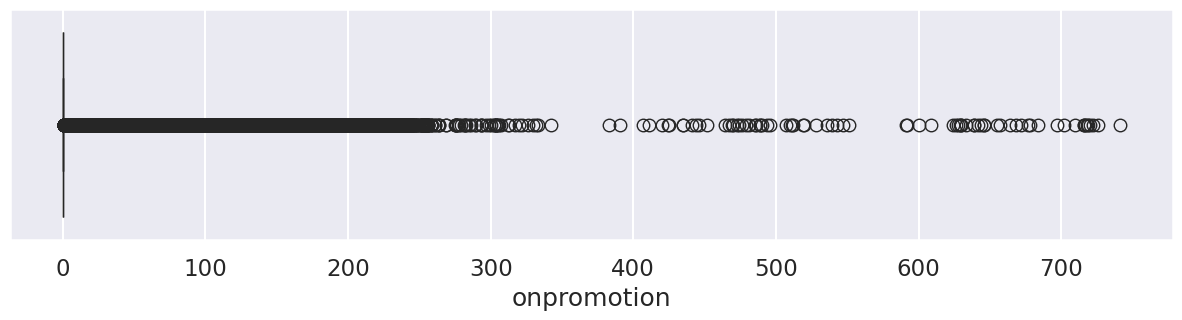

In [37]:
hist_box_plot(df[['onpromotion']], 'onpromotion', kde=True)

Removed 36271 outliers, ratio - 1.2%


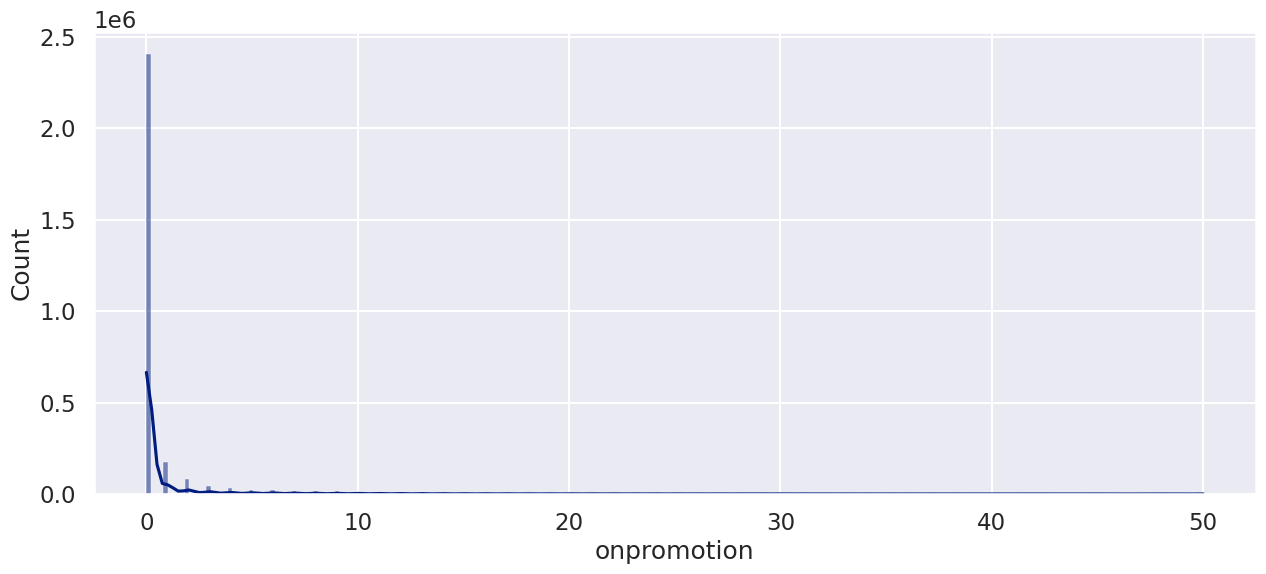

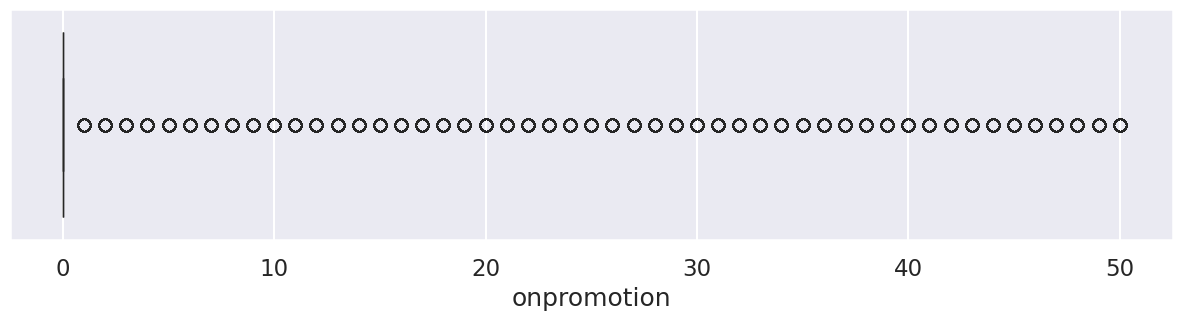

In [38]:
query = '(onpromotion <= 50) | (is_submission == True)'
queries.append(query)
df2 = df[['onpromotion', 'is_submission']].query(query)
df2.loc[df2['is_submission'], 'onpromotion'] = (
    df2.loc[df2['is_submission'], 'onpromotion'].clip(None, 50)
)
message(df, df2)

hist_box_plot(df2, 'onpromotion', kde=True)

## B. Categorical columns

### 1. family

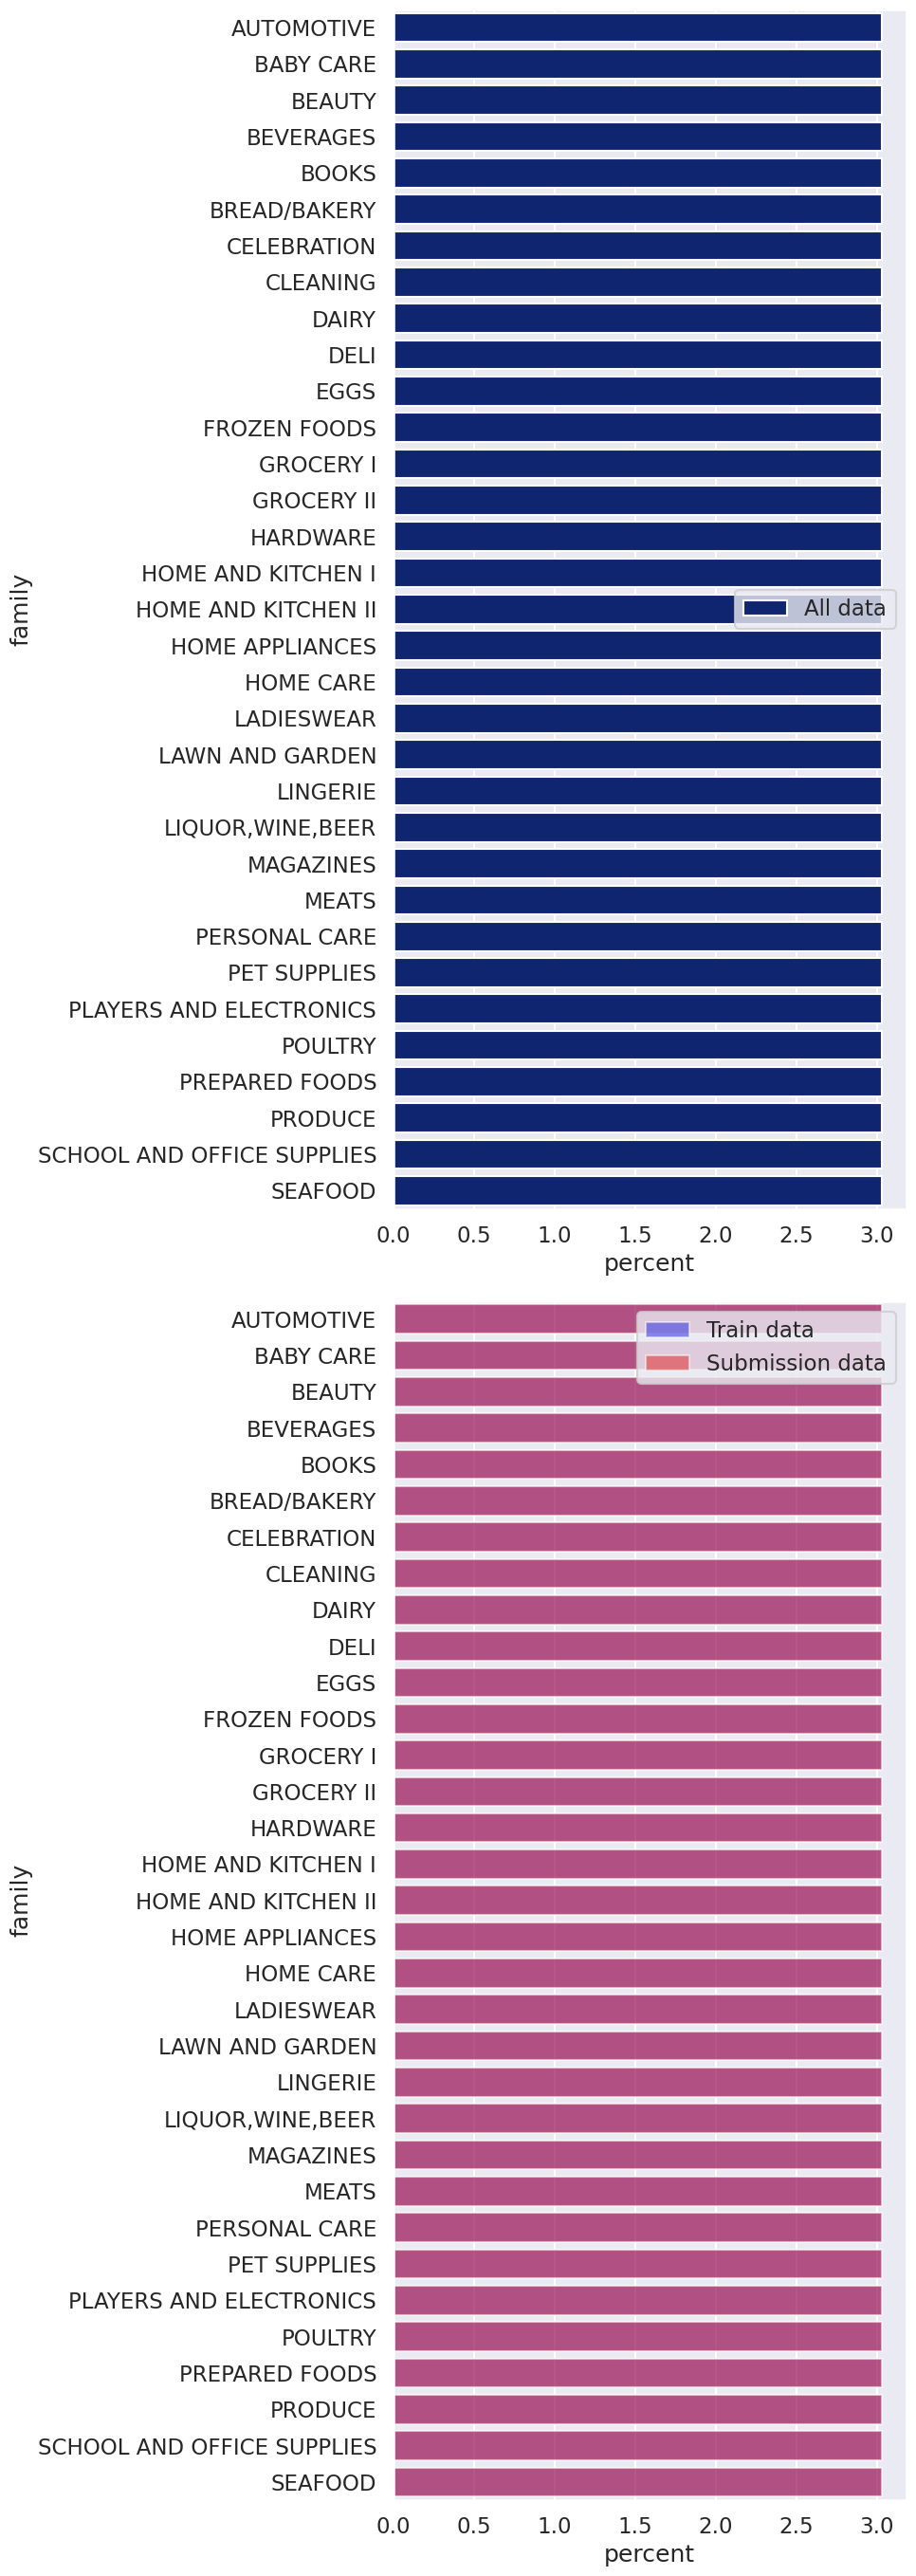

In [40]:
col = 'family'
train_submission_countplot(
    df=df[[col, 'is_submission']],
    col=col,
    is_submission_col='is_submission'
)

Looks like this is a uniform distribution with no outliers

### 2. city

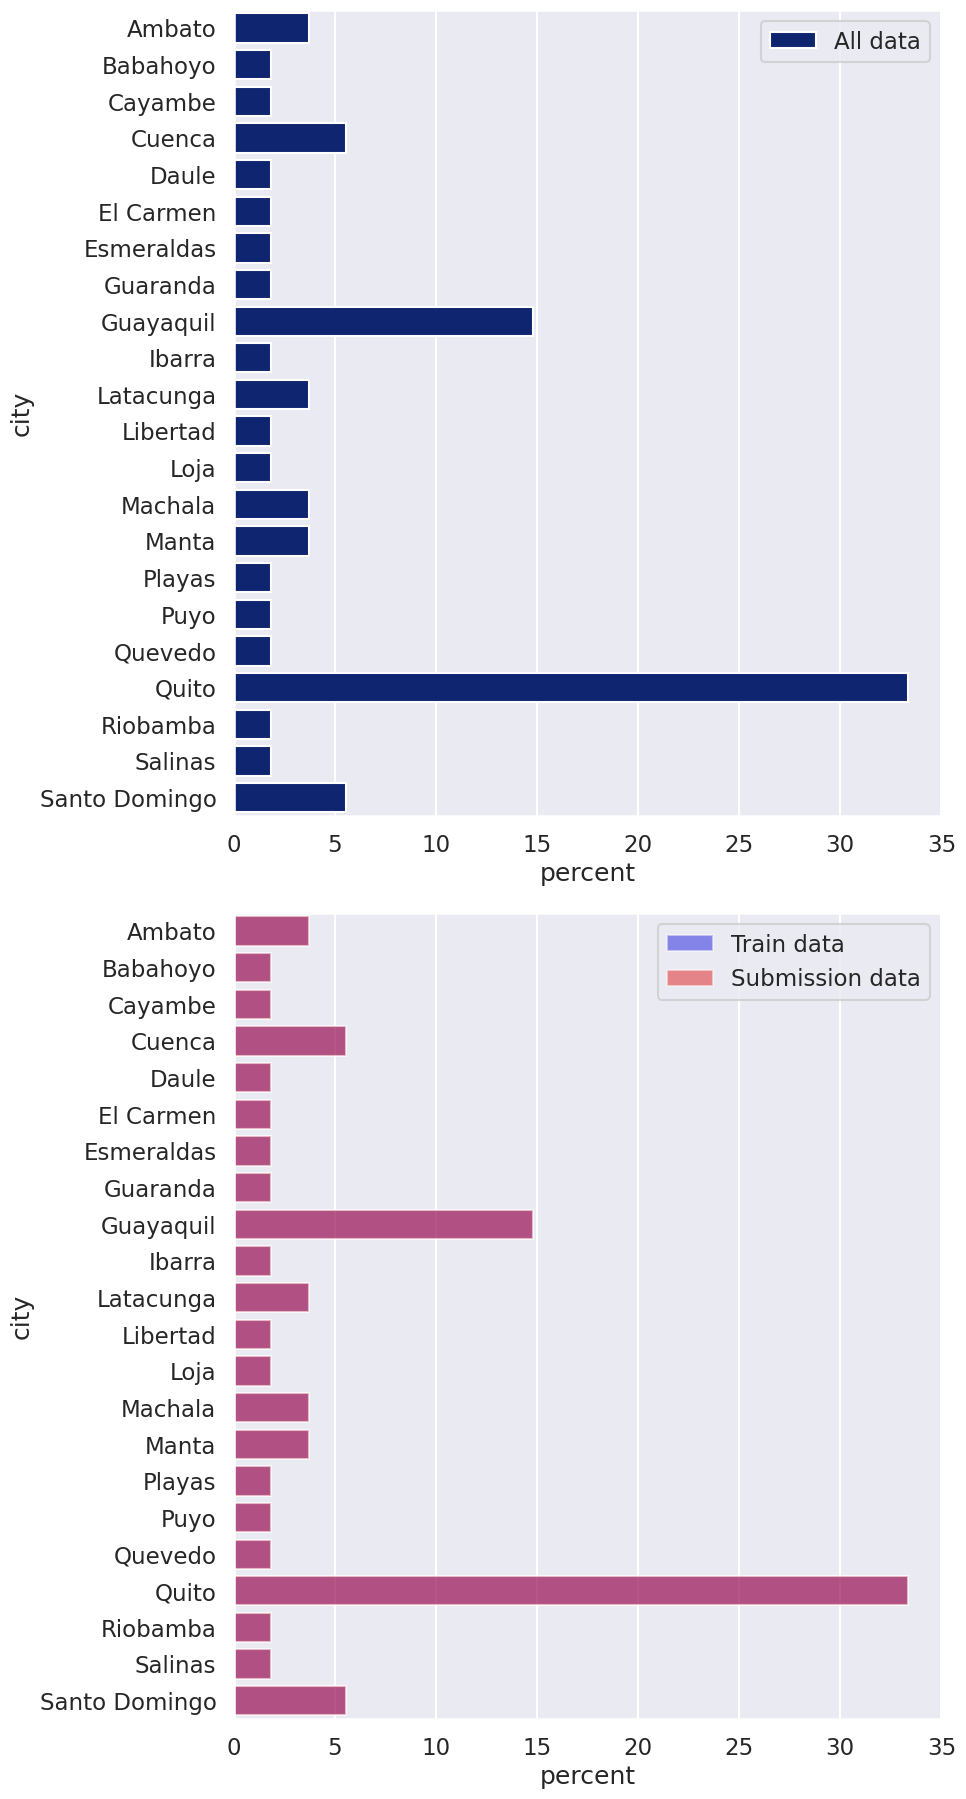

In [41]:
col = 'city'
train_submission_countplot(
    df=df[[col, 'is_submission']],
    col=col,
    is_submission_col='is_submission'
)

Though it is not a uniform distriution, there are no outliers.  
Moreover, the distribution is the same for both train and submission subsets

### 3. state

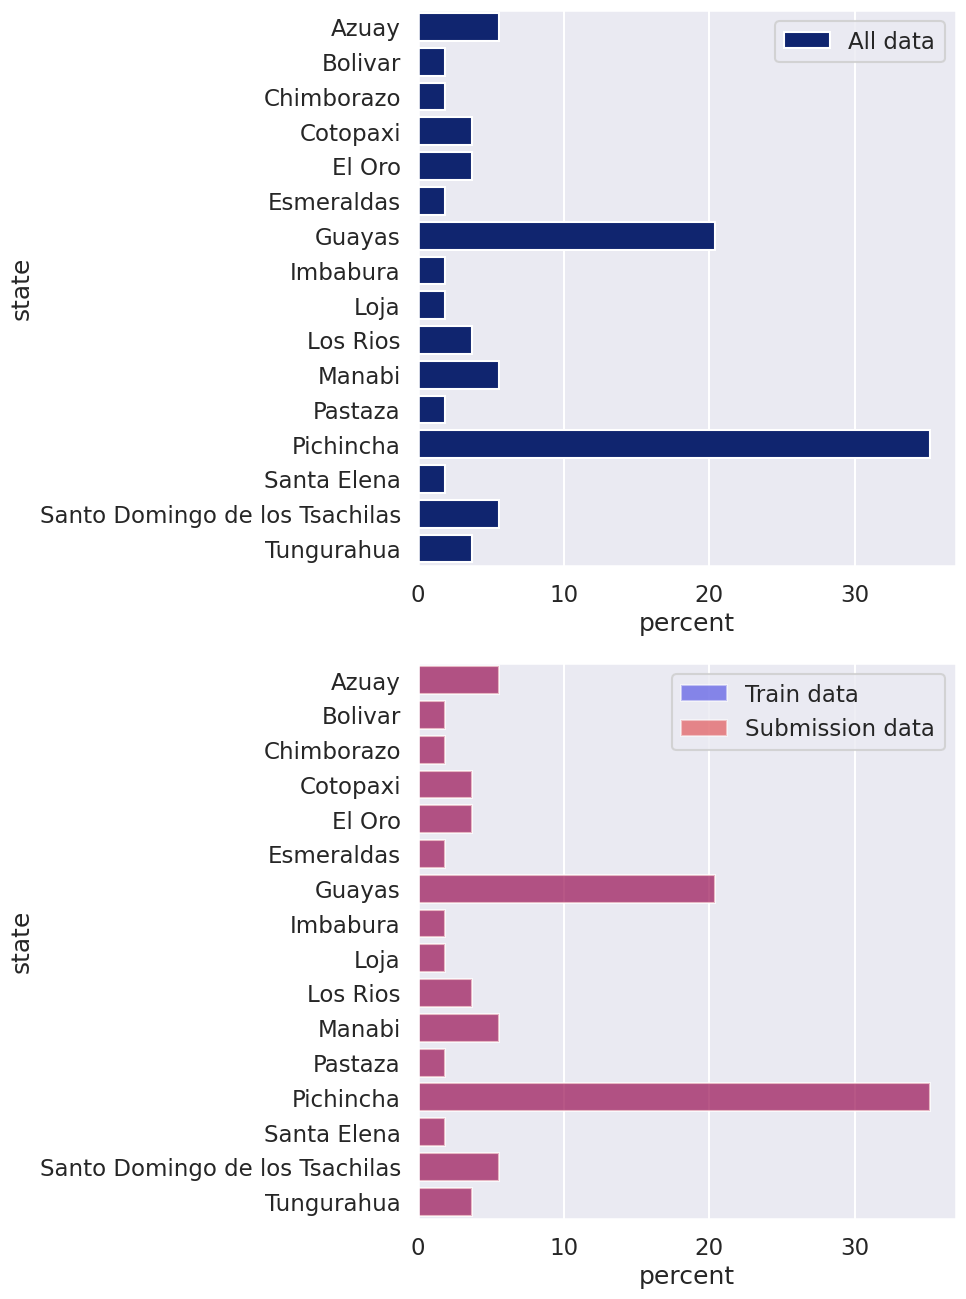

In [42]:
col = 'state'
train_submission_countplot(
    df=df[[col, 'is_submission']],
    col=col,
    is_submission_col='is_submission'
)

No outliers.  
The distribution is the same for both train and submission subsets

### 4. type

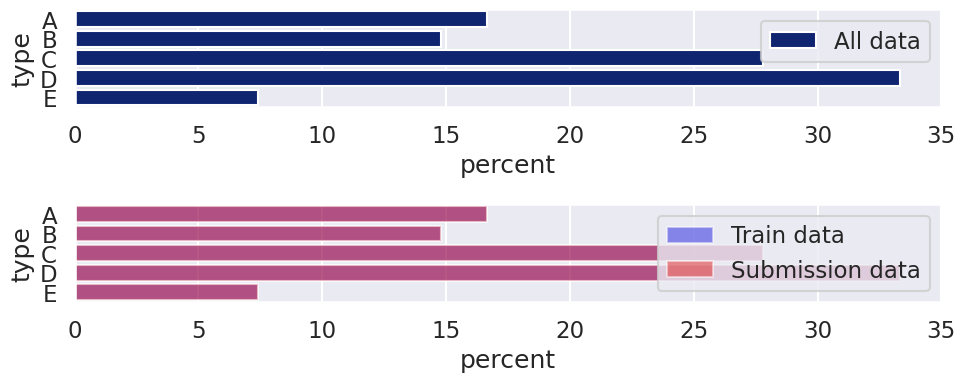

In [43]:
col = 'type'
train_submission_countplot(
    df=df[[col, 'is_submission']],
    col=col,
    is_submission_col='is_submission'
)

No outliers.  
The distribution is the same for both train and submission subsets

### 5. cluster

Text(0, 0.5, 'percent')

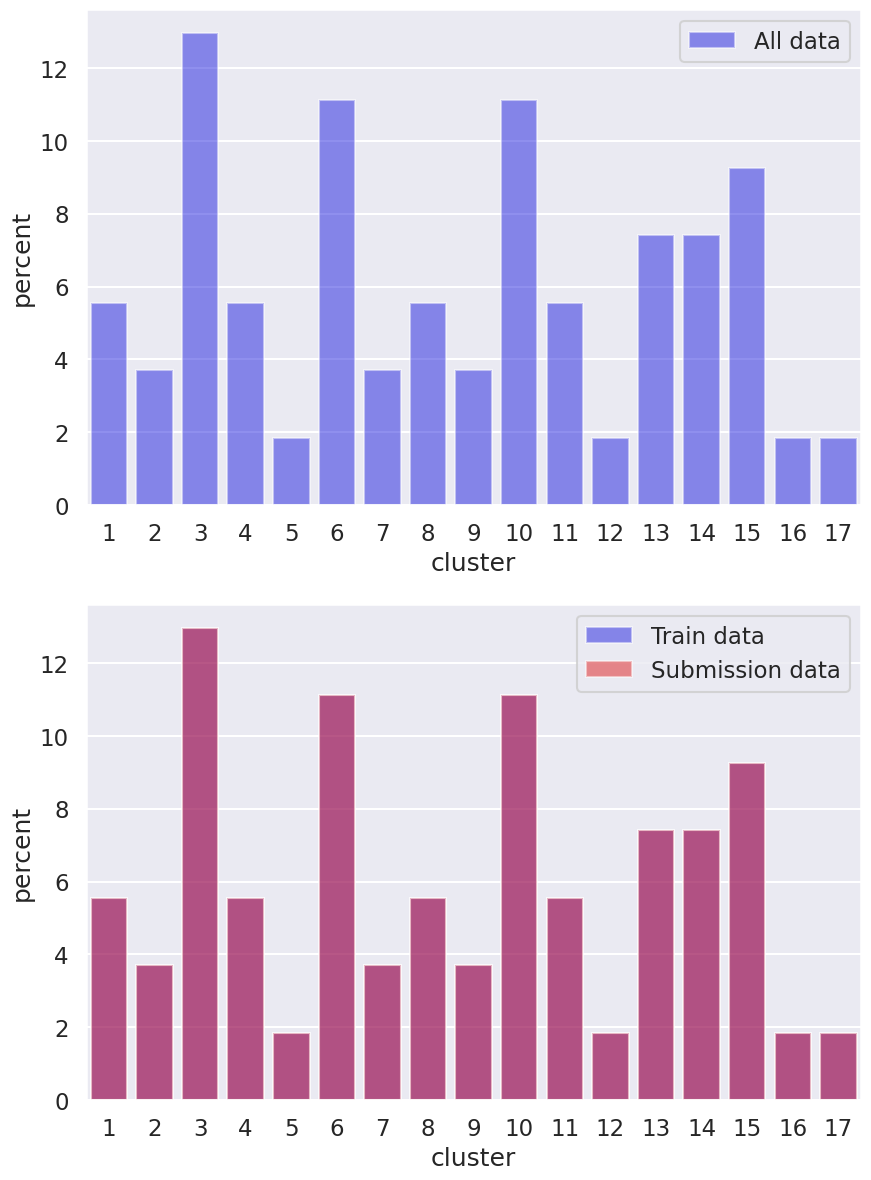

In [44]:
col = "cluster"
fig, ax = plt.subplots(2, 1, figsize=(10, 2 * 10 / 24 * df[col].nunique()))
sns.barplot(
    df[col].value_counts().sort_index()/len(df)*100,
    color="blue",
    alpha=0.5,
    ax=ax[0],
    label="All data",
)
ax[0].legend()
ax[0].set_ylabel('percent')
sns.barplot(
    df.query("not is_submission")[col].value_counts().sort_index()/len(df.query("not is_submission"))*100,
    color="blue",
    alpha=0.5,
    label="Train data",
    ax=ax[1],
)
sns.barplot(
    df.query("is_submission")[col].value_counts().sort_index()/len(df.query("is_submission"))*100,
    color="red",
    alpha=0.5,
    label="Submission data",
    ax=ax[1],
)
ax[1].legend()
ax[1].set_ylabel('percent')

No outliers.  
The distribution is the same for both train and submission subsets

## C. Date columns

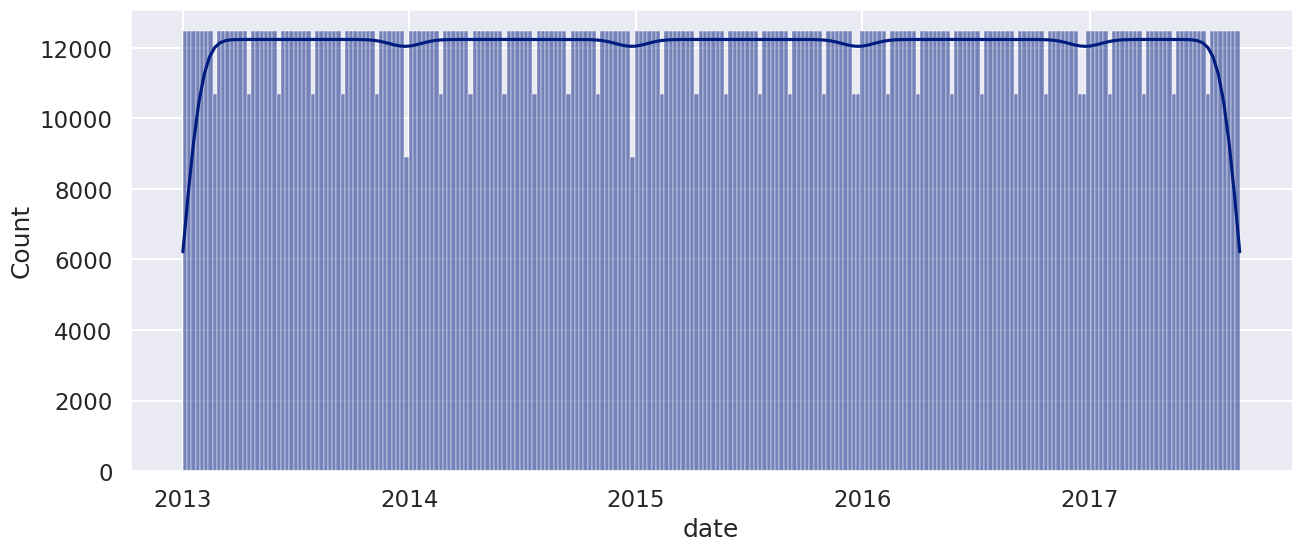

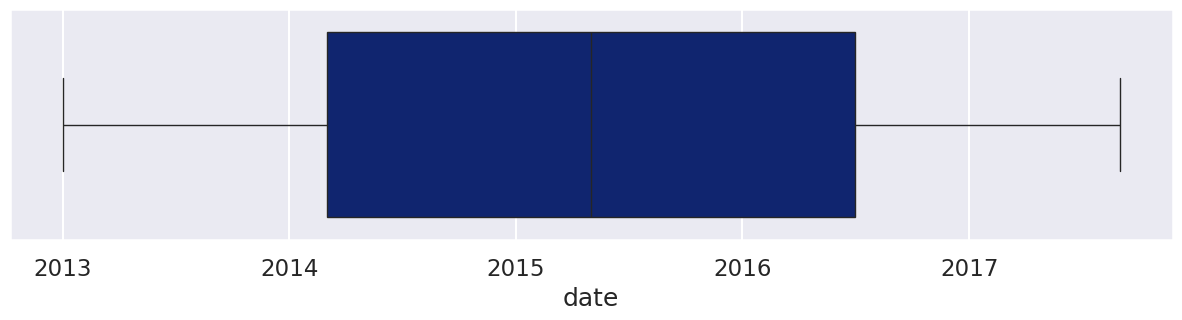

In [45]:
hist_box_plot(df, date_col, kde=True)

The date column's distribution is close to uniform

## D. Applying all transformations

In [25]:
iqr_feats = {
    'sales': 15,
    'transactions': 3
}
queries = [
    '(onpromotion <= 50) | (is_submission == True)'
]

In [35]:
df2 = df.copy()

for query in queries:
    df2 = df2.query(query)
df2.loc[df2['is_submission'], 'onpromotion'] = (
    df2.loc[df2['is_submission'], 'onpromotion'].clip(None, 50)
)

df2 = iqr_filter(data=df2, features=iqr_feats, verbose=False, is_submission_col='is_submission')

print(f"Number of observations before dropping outliers: {len(df)}")
print(f"Number of observations after dropping outliers: {len(df2)}")
print(f"Ratio: {round(100*len(df2)/len(df), 2)}%")
print(f"Number of outlier observations dropped: {len(df) - len(df2)}")
print(f"Ratio: {round(100*(1 - len(df2)/len(df)), 2)}%")


Number of observations before dropping outliers: 3029400
Number of observations after dropping outliers: 2896084
Ratio: 95.6%
Number of outlier observations dropped: 133316
Ratio: 4.4%


It can be seen that less than 5 % of the data was identified as outliers and has been removed,  
which is a good sign since not too much data was lost.

## E. Multidimensional outliers



So far, outliers have been considered per each features separately. However, it is possible to distinguish outliers  based on the combination of features.  
There are some methods to detect outliers in the high-dimensional space.  
Let's consider one of them - Isolation Forest.  
Since about 5% of the data has already been dropped, the contamination rate will be set to 0.01 (1 %)  


In [39]:
from sklearn.preprocessing import LabelEncoder


df3 = df2.copy()

label_encoder = LabelEncoder()
for col in cat_cols:
    df3[col] = label_encoder.fit_transform(df3[col])

model = IsolationForest(contamination=0.01, random_state=42)
is_outlier = model.fit_predict(df3.query('is_submission == False')[num_cols + cat_cols])

df3 = df2.copy()
df3['outlier'] = 1
df3.loc[~df3['is_submission'], 'outlier'] = is_outlier
df3 = df3.query('outlier == 1').drop(columns=['outlier'])

print(f"Number of observations before dropping outliers: {len(df)}")
print(f"Number of observations after dropping outliers: {len(df3)}")
print(f"Ratio: {round(100*len(df3)/len(df), 2)}%")
print(f"Number of outlier observations dropped: {len(df) - len(df3)}")
print(f"Ratio: {round(100*(1 - len(df3)/len(df)), 2)}%")

Number of observations before dropping outliers: 3029400
Number of observations after dropping outliers: 2867408
Ratio: 94.65%
Number of outlier observations dropped: 161992
Ratio: 5.35%


# V. Saving data

In [42]:
df3.set_index('id').to_csv('../data/artifacts/cleaned_data.csv', chunksize=100000)